# HW03 - Machine Learning for Cancer-Risk Screening - Perceptron and Always-0 Classifier(s); ROC Curves; Precision and Recall

### Authors: Maida Raza

### Assignment description: 

In this assignment, I built and evaluated classifiers to predict cancer risk from patient data. I compared a simple, always-0 baseline classifier to a trained Perceptron model, applied scaling and regularization, and converted Perceptron outputs into probabilistic predictions using calibration techniques. I then analyzed the trade-off between precision and recall, evaluated model performance with ROC curves, and chose the most appropriate threshold for decision-making.

### Import required libraries.

Author imports more libraries, as needed, below.

In [98]:
import os
import numpy as np
import pandas as pd

import warnings

import sklearn.linear_model
import sklearn.metrics
import sklearn.calibration

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
!pip install seaborn

plt.style.use('seaborn-v0_8') # pretty matplotlib plots

### Function for later use
This function will compute and return a confusion matrix on data, given probabilistic predictions, and a threshold to use when converting probabilities to "firm" predictions.



In [ ]:
def calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh=0.5):
    
    cm = sklearn.metrics.confusion_matrix(ytrue_N, yproba1_N >= thresh)
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    return cm_df

## Cancer-Risk Screening

### 1: Compute true/false positives/negatives.

This function should take in two vectors of the same length, one consisting of known correct output values (0 or 1) for a classification task, and the other consisting of the actual output values for some classifier. It
will then compute the number of true/false positive/negative values found in the classifier output, and return them.


In [ ]:
def calc_TP_TN_FP_FN(ytrue_N, yhat_N):
    correct_0 = []
    correct_1 = []
    incorrect_0 = []
    incorrect_1 = []
    
    if len(ytrue_N) == len(yhat_N):
        for i in range(len(ytrue_N)):
            if ytrue_N[i] == yhat_N[i]:
                if yhat_N[i] == 1:
                    correct_1.append(yhat_N[i])
                else:
                    correct_0.append(yhat_N[i])
            else: 
                if yhat_N[i] == 1:
                    incorrect_1.append(yhat_N[i]) 
                else:
                    incorrect_0.append(yhat_N[i]) 
                
    else:
        return("Error: The length of the lists is not same")
    incorrect_0 = [int(j) for j in incorrect_0]        
    incorrect_1 = [int(k) for k in incorrect_1]
    correct_0 = [int(l) for l in correct_0]
    correct_1 = [int(m) for m in correct_1]
    
    TP = len(correct_1)
    TN = len(correct_0)
    FP = len(incorrect_1)
    FN = len(incorrect_0)
    
    return TP, TN, FP, FN

input_1 = np.array([0,1,1,1])
input_2 = np.array([1,1,1,0])

calc_TP_TN_FP_FN(input_1, input_2)

(2, 0, 1, 1)

#### Testing code
The following four calls to the function above to test the results.

In [101]:
all0 = np.zeros(10)
all1 = np.ones(10)
calc_TP_TN_FP_FN(all0, all1)

(0, 0, 10, 0)

In [102]:
calc_TP_TN_FP_FN(all1, all0)

(0, 0, 0, 10)

In [103]:
calc_TP_TN_FP_FN(all1, all1)

(10, 0, 0, 0)

In [104]:
calc_TP_TN_FP_FN(all0, all0)

(0, 10, 0, 0)

### Load the datasets

Here, we are simply loading the datasets


In [105]:
# Load the x-data and y-class arrays
x_train = np.loadtxt('./data_cancer/x_train.csv', delimiter=',', skiprows=1)
x_test = np.loadtxt('./data_cancer/x_test.csv', delimiter=',', skiprows=1)

y_train = np.loadtxt('./data_cancer/y_train.csv', delimiter=',', skiprows=1)
y_test = np.loadtxt('./data_cancer/y_test.csv', delimiter=',', skiprows=1)

#### Scaling the data: 

After running both Perceptron and Always-0 classifiers without scaling, I was getting the same results. This is mainly because our data has features with varying numerical ranges. I will scale x_test and x_train to be in the [0,1] range only. 

In [106]:

# Scaling the data
from sklearn.preprocessing import MinMaxScaler

scale = MinMaxScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test) 


### 2: Compute the fraction of patients with cancer

For each of the input sets (train, test), we want to know the proportion of patients that do/do not have cancer

In [ ]:
# For verification purposes only.

train_1 = [m for m in y_train if m == 1.0]
train_0 = [n for n in y_train if n == 0.0]

test_1 = [o for o in y_test if o == 1.0]
test_0 = [p for p in y_test if p == 0.0]

len(train_1), len(train_0), len(test_1), len(test_0)

(80, 490, 25, 155)

##### Total observations in test set: 180

##### Total observations in train set: 570

In [ ]:
# Code for determining the proportion of cancer v. non-cancer patients:

import pandas

test_cancer = []
test_nocancer = []
train_cancer = []
train_nocancer = []
total_len_test = len(y_test)
total_len_train = len(y_train)

for i in y_test:
    if i == 0.0:
        test_nocancer.append(i)
    else:
        test_cancer.append(i)

for m in y_train:
    if m == 0.0:
        train_nocancer.append(m)
    else:
        train_cancer.append(m)
        
frac_test_cancer = len(test_cancer)/total_len_test
frac_train_cancer = len(train_cancer)/total_len_train

print(f"Fraction of data that has_cancer on TRAIN: {frac_train_cancer:.3f}") 
print(f"fraction of data that has_cancer on TEST : {frac_test_cancer:.3f}")

Fraction of data that has_cancer on TRAIN: 0.140
fraction of data that has_cancer on TEST : 0.139


### 3: The predict-0-always baseline

An "always 0 classifier" is a simple baseline model that always predicts class 0, regardless of the input data. Dummy Classifier in Scikit-learn is used to create a baseline performance metric/classifier. It does not learn anything from the data, however, it is useful in the cases where data is imbalanced. 

#### (a) Compute the accuracy of the always-0 classifier on test and train sets.



In [ ]:
# I am understanding this to say that how many times always-0 will be correct in predicting zero in both test and train datasets

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy = DummyClassifier(strategy = 'constant', constant = 0)

# fit the training data on the dummy model and then use it to predict the test results. We will then compute the accuracy score using accuracy_score from scikit-learn
dummy.fit(x_train, y_train)
y_predict_dummy = dummy.predict(x_test)
y_train_predict_dummy = dummy.predict(x_train)


print(f"acc on TRAIN: {accuracy_score(y_train, y_train_predict_dummy):.3f}") 
print(f"acc on TEST : {accuracy_score(y_test, y_predict_dummy):.3f}")

acc on TRAIN: 0.860
acc on TEST : 0.861


#### (b) Print a confusion matrix for the always-0 classifier

Note that, I am calling the functions that I built above

In [ ]:
print(calc_confusion_matrix_for_threshold(y_test, y_predict_dummy))
print(calc_confusion_matrix_for_threshold(y_train, y_train_predict_dummy))


Predicted    0  1
True             
0          155  0
1           25  0
Predicted    0  1
True             
0          490  0
1           80  0


#### (c) Reflect on the accuracy of the always-0 classifier.

**Answer**:

The Always-0 classifier predicts every instance as class 0, regardless of input. While this may yield high accuracy in imbalanced datasets — like ours, where most samples belong to class 0 — it is not a meaningful model for tasks such as cancer detection.

This high accuracy is misleading. The model achieves it by exploiting the class imbalance, not by learning any patterns. In our case, although accuracy appears reasonable, the model fails to identify any positive cases (i.e., patients with cancer). The confusion matrix confirms this, showing that all 25 actual positives are misclassified as negatives.

This failure is especially critical given our task: detecting cancer. Here, recall (true positive rate) is far more important than overall accuracy. The Always-0 model's recall is 0, making it useless for our primary goal.

In contrast, even models with lower overall accuracy but better recall would be preferred, as they at least identify some cancer cases. This demonstrates the importance of choosing evaluation metrics aligned with the real-world costs of misclassification. In this context, missing a cancer case (false negative) is far more costly than a false positive.

#### (d) Analyze the various costs of using the always-0 classifier (if you are tasked with determining if patients have cancer without doing a biopsy first).


**Answer**: 

Using the Always-0 classifier in this context is highly costly and potentially harmful, as it consistently fails to identify patients with cancer (class 1):

The model will misclassify all cancer-positive patients as cancer-free (class 0). This is particularly dangerous because some patients may be in advanced stages and cannot afford delays in diagnosis. If a patient chooses to forego a biopsy and relies solely on this test, the consequences could be life-threatening.

From an institutional perspective, deploying such an ineffective classifier exposes the hospital to serious legal and ethical risks. If a misdiagnosed patient dies or suffers harm, the hospital could face lawsuits, resulting in substantial financial penalties and long-term reputational damage.

Given that the dataset is highly imbalanced—heavily skewed toward non-cancer cases—I strongly discourage the use of the Always-0 classifier because it does not help us address the problem statement: identify patients with Cancer!

### 4: Basic Perceptron Models

#### (a) Create a basic `Perceptron` classifier

Fit a perceptron to the training data.  Print out accuracy on this data, as well as on testing data.  Print out a confusion matrix on the testing data.

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

model = Perceptron()
model.fit(x_train, y_train)

# Predicting on the train set
y_train_predict = model.predict(x_train)

# Predicting on the test set
y_test_predict = model.predict(x_test)

# Calculating the accuracy score on both test and train sets
acc_score_train = accuracy_score(y_train, y_train_predict)
acc_score_test = accuracy_score(y_test, y_test_predict)

print(f"acc on TRAIN: {acc_score_train:.3f}") 
print(f"acc on TEST :{acc_score_test:.3f}")
print(f'\nConfusion Matrix for the test set: \n\n{calc_confusion_matrix_for_threshold(y_test, y_test_predict)}')

acc on TRAIN: 0.402
acc on TEST :0.494

Confusion Matrix for the test set: 

Predicted   0   1
True             
0          64  91
1           0  25


#### (b) Compare the `Perceptron` to the always-0 classifier.

**Answer**: 

After scaling both the training and test datasets using MinMaxScaler, the accuracy of the Always-0 classifier remained unchanged. In contrast, the Perceptron model achieved an accuracy of 40.2% on the training set and 49.4% on the test set—compared to 86.0% and 86.1% for the Always-0 classifier on the respective sets.

However, accuracy alone does not tell the full story. The confusion matrix for the Perceptron model on the test set shows that it correctly identified all 25 positive cases (patients with cancer), and—crucially—it produced no false negatives. This is a significant improvement over the Always-0 classifier, which misclassifies all positive cases as negatives. While the Perceptron model does classify 58% of negative cases as false positives, this is a tradeoff worth accepting in the medical context of cancer detection.

Our primary objective in this task is to minimize false negatives, as missing a cancer diagnosis can have severe, potentially fatal consequences. In contrast, false positives—while inconvenient—can be followed up with confirmatory tests like biopsies, which are part of standard medical practice.

Therefore, despite its lower overall accuracy, the Perceptron model is far more aligned with our real-world objective and represents a more reliable option than the Always-0 baseline. Moving forward, applying more sophisticated models such as Logistic Regression or Random Forest could help reduce the number of false positives while maintaining the zero false negative rate—leading to a better balance between sensitivity and precision.

#### (c) Generate a series of regularized perceptron models
Each model will use a different `alpha` value, multiplying that by the L2 penalty.  You will record and plot the accuracy of each model on both training and test data.

In [ ]:
alphas = np.logspace(-5,5,base=10, num=100)
x_ticks = []
test_accuracy = []
train_accuracy = []

for i in alphas:
    x_ticks.append(i)
    
    model = Perceptron(alpha=i, penalty='l2')
    model.fit(x_train, y_train)
    y_train_predict = model.predict(x_train)
    y_test_predict = model.predict(x_test)
    train_acc_score = accuracy_score(y_train, y_train_predict)
    test_acc_score = accuracy_score(y_test, y_test_predict)
    test_accuracy.append(test_acc_score)
    train_accuracy.append(train_acc_score)
    
print(f'train_accuracy_list = {train_accuracy}')
print(f'test_accuracy_list = {test_accuracy}')


train_accuracy_list = [0.8596491228070176, 0.8, 0.8666666666666667, 0.8596491228070176, 0.8614035087719298, 0.8666666666666667, 0.8736842105263158, 0.8649122807017544, 0.8614035087719298, 0.8666666666666667, 0.8631578947368421, 0.8701754385964913, 0.8649122807017544, 0.8596491228070176, 0.8824561403508772, 0.45087719298245615, 0.8649122807017544, 0.5771929824561404, 0.2964912280701754, 0.868421052631579, 0.8614035087719298, 0.8631578947368421, 0.8842105263157894, 0.8614035087719298, 0.8596491228070176, 0.8596491228070176, 0.8631578947368421, 0.875438596491228, 0.8596491228070176, 0.14035087719298245, 0.14035087719298245, 0.8666666666666667, 0.8649122807017544, 0.8596491228070176, 0.8596491228070176, 0.8596491228070176, 0.8596491228070176, 0.8596491228070176, 0.8596491228070176, 0.8596491228070176, 0.8596491228070176, 0.8596491228070176, 0.8596491228070176, 0.8596491228070176, 0.8596491228070176, 0.8596491228070176, 0.8596491228070176, 0.8596491228070176, 0.8596491228070176, 0.859649122

##### Plot accuracy on train/test data across the different alpha values.

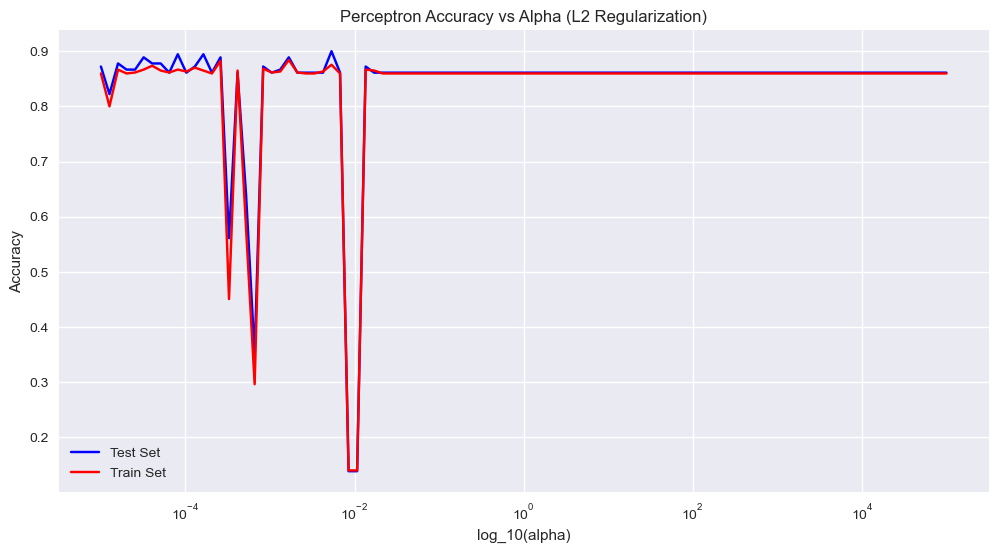

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(x_ticks, test_accuracy, label = "Test Set", color = 'blue')
plt.plot(x_ticks, train_accuracy, label = 'Train Set', color ='red')
plt.xscale('log')
plt.legend()
plt.xlabel('log_10(alpha)')
plt.ylabel('Accuracy')
plt.title('Perceptron Accuracy vs Alpha (L2 Regularization)')   
plt.show()

#### (d) Discuss what the plot is showing you

**Answer**: 

The Perceptron model performs best with minimal regularization — very low values of alpha. For example, 10^-4 yields the highest test accuracy. Perceptron becomes insensitive to higher alphas, as demonstrated by both test and train accuracies stabalizing after 10^-2. At low regularization values, test accuracy occasionally exceeds train accuracy, likely due to noise or underfitting at certain alpha values. This further suggests the model benefits from light regularization but not strong penalties. Unlike Ridge regression, where increasing alpha gradually shrinks weights and improves generalization by reducing MSE, the Perceptron’s performance is less stable due to its binary loss and step-based updates. This results in sudden performance drops at moderate alpha values

### 5: Decision functions and probabilistic predictions

#### (a) Create two new sets of predictions

Fit `Perceptron` and `CalibratedClassifierCV` models to the data.  Use their predictions to generate ROC curves. 

* Confidence Score: tells us how certain the model is that each data-point is in the assigned class, it is calculated for every single data point. It, essentially, is a probability measure.

In [127]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, auc 

# fitting the Perceptron model and generating its decision_function() over the test data.

model_revised = Perceptron()
model_revised.fit(x_train, y_train)
y_test_predict = model_revised.predict(x_test)

# Generating the confidence scores for the test data 
confidence_score = model_revised.decision_function(x_test) 

# Creating the CCCV model - we use CCCV because Perceptron cannot handle float data

model_2 = CalibratedClassifierCV(model_revised, method='isotonic')
model_2.fit(x_train, y_train)
y_test_predict_CCCV = model_2.predict(x_test)
y_test_probabilities = model_2.predict_proba(x_test)[:,1]

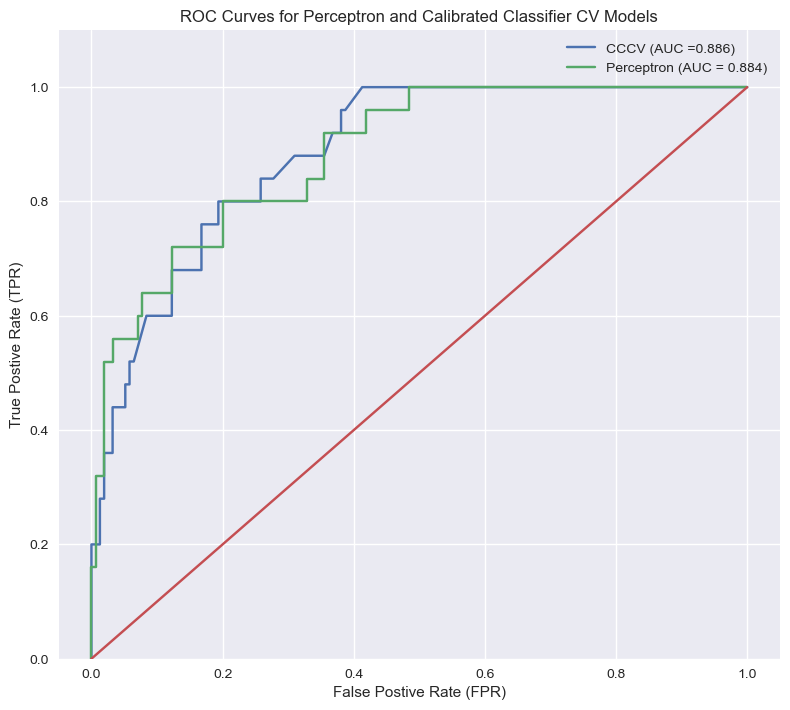

In [ ]:
# Plotting the ROC-AUC curve. Essentially, this curve tells us the trade-off between TPR and FPR. Ideally, we want
# the curve to reach TPR == 1 faster, so our model produces less false positives.

fpr_cccv, tpr_cccv, threshold_cccv = roc_curve(y_test, y_test_probabilities)
fpr_per, tpr_per, threshold_per = roc_curve(y_test, confidence_score)

roc_auc_cccv = auc(fpr_cccv, tpr_cccv)
roc_auc_per = auc(fpr_per, tpr_per)

plt.figure(figsize=(8,7))
plt.plot(fpr_cccv,tpr_cccv, label = f"CCCV (AUC ={roc_auc_cccv:.3f})")
plt.plot(fpr_per,tpr_per, label= f"Perceptron (AUC = {roc_auc_per:.3f})")
plt.plot([0,1], [0,1])
plt.ylim([0, 1.1])
plt.xlabel("False Postive Rate (FPR)")
plt.ylabel("True Postive Rate (TPR)")
plt.legend()
plt.tight_layout()
plt.title("ROC Curves for Perceptron and Calibrated Classifier CV Models")
plt.show()


In [116]:
print(f"AUC on TEST for Perceptron: {roc_auc_cccv*100:.3f}" ) #TODO: modify these values
print(f"AUC on TEST for probabilistic model: {roc_auc_per*100:.3f}")


AUC on TEST for Perceptron: 88.581
AUC on TEST for probabilistic model: 88.439


#### (b) Discuss the results above

**Answer**: AUC, or Area Under The Curve shows us the trade-off between FPR and TPR. The purposes of our problem is to predict whether a patient has Cancer or does not have Cancer before the biopsy. As shown above Calibrated-Classifier achieves a TPR = 1 much quickly than Perceptron. While the difference is minimal and the costs of False Positives is not high in this problem, Calibrated-Classifier is still a better model because it reduces the number of False Positives. 

#### (c) Compute model metrics for different probabilistic thresholds

Compute a function that takes in a set of correct outputs, a matching set of probabilities generated by a classifier, and a threshold at which to set the positive decision probability, and returns a set of metrics if we use that threshold.

In [ ]:
# Print out test probabilities to understand it
y_test_probabilities.tolist()


[0.021031207598371775,
 0.036415822982987164,
 0.03529232330460214,
 0.41266565507166675,
 0.021031207598371775,
 0.07450714342724879,
 0.0,
 0.39668495647821905,
 0.0,
 0.15802316642436334,
 0.1113369802570856,
 0.137467682743951,
 0.3896256684491978,
 0.0798828822395201,
 0.1113369802570856,
 0.9199999999999999,
 0.042709529276693456,
 0.00909090909090909,
 0.021031207598371775,
 0.0,
 0.0,
 0.017234150887951754,
 0.021031207598371775,
 0.021031207598371775,
 0.021031207598371775,
 0.0,
 0.17165775401069522,
 0.10517132143227784,
 0.021031207598371775,
 0.07170994063004599,
 0.1576606600172979,
 0.12753131224089126,
 0.19088069506547156,
 0.2256758692278856,
 0.0,
 0.12753131224089126,
 0.021031207598371775,
 0.021031207598371775,
 0.30054793498543775,
 0.021031207598371775,
 0.2702914456047999,
 0.0,
 0.30103425985778925,
 0.0,
 0.08989175881186418,
 0.2758594346829641,
 0.18570124688141415,
 0.021031207598371775,
 0.00909090909090909,
 0.6123529411764705,
 0.07170994063004599,
 0.2

In [129]:
# (4) Once we have generated the output of a probabilistic classifier on some data, we
# can compute its performance relative to probability threshold TP , where we decide to
# classify any data with output P   TP as a 1, else a 0. (So, for instance, setting TP = 0:0
# means that all data is classified as part of the positive (1) class

def calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh=0.5):
    
    y_pred = [1 if p >= thresh else 0 for p in yproba1_N]
    Metrics = calc_TP_TN_FP_FN(ytrue_N, y_pred)

    acc_model = accuracy_score(y_test, y_pred)
    acc = (Metrics[0] + Metrics[1])/len(y_test)
    tpr = (Metrics[0])/(Metrics[0] + Metrics[3])
    tnr = (Metrics[1])/(Metrics[1] + Metrics[2])
    ppv = (Metrics[0])/(Metrics[0] + Metrics[2]) if (Metrics[0] + Metrics[2])  > 0 else 0
    npv = (Metrics[1])/(Metrics[1] + Metrics[3]) if (Metrics[1] + Metrics[3])  > 0 else 0
    
    #print("Accuracy Score you should get:", acc_model)
    return acc, tpr, tnr, ppv, npv
calc_perf_metrics_for_threshold(y_test, y_test_probabilities) 

(0.8888888888888888,
 0.4,
 0.967741935483871,
 0.6666666666666666,
 0.9090909090909091)

In [130]:
# Function to make printing results easier
def print_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh=0.5):
    ''' Pretty print perf. metrics for a given probabilistic classifier and threshold
    '''
    acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh=thresh)
    
    ## Pretty print the results
    print("%.3f ACC" % acc)
    print("%.3f TPR" % tpr)
    print("%.3f TNR" % tnr)
    print("%.3f PPV" % ppv)
    print("%.3f NPV" % npv)
    
print_perf_metrics_for_threshold(y_test, y_test_probabilities)

0.889 ACC
0.400 TPR
0.968 TNR
0.667 PPV
0.909 NPV


#### (d) Compare the probabilistic classifier across multiple decision thresholds

Try a range of thresholds for classifying data into the positive class (1).  For each threshold, compute the true positive rate (TPR) and positive predictive value (PPV).  Record the best value of each metric, along with the threshold that achieves it, and the *other* metric at that threshold.

In [ ]:
# enumerate gives you both the index and teh value at that index

TPR = []
PPV = []
thresh = []
threshold = np.linspace(0, 1.001, 51)
Acc = []
TNR = []
False_P = []

for i in threshold:
    thresh.append(i)
    y_designation = [1 if p >= i else 0 for p in y_test_probabilities]
    TP, TN, FP, FN = calc_TP_TN_FP_FN(y_test, y_designation)

    acc = (TP + TN) / len(y_test)
    tpr = TP / (TP + FN) if (TP + FN) > 0 else 0
    tnr = TN / (TN + FP) if (TN + FP) > 0 else 0
    ppv = TP / (TP + FP) if (TP + FP) > 0 else 0

    TPR.append(tpr)
    PPV.append(ppv)
    Acc.append(acc)
    TNR.append(tnr)
    False_P.append(FP)

best_TPR = max(TPR)
tpr_candidates = [i for i, val in enumerate(TPR) if val == best_TPR]
best_TPR_index = max(tpr_candidates, key=lambda i: PPV[i]) # this essentially looks at PPV at every index identified by tpr_candidates and then gives us the best PPV
best_PPV_for_best_TPR = PPV[best_TPR_index]
best_TPR_threshold = thresh[best_TPR_index]

best_PPV = max(PPV)
ppv_candidates =[m for m, val in enumerate(PPV) if val == best_PPV]
best_PPV_index = max(ppv_candidates, key = lambda i: TPR[i])
best_TPR_for_best_PPV = TPR[best_PPV_index]
best_PPV_threshold = thresh[best_PPV_index]

# Best TPR Threshold:
print("Highest TPR =", best_TPR)
print("Threshold at Highest TPR = ", best_TPR_threshold)
print("PPV at Highest TPR =", best_PPV_for_best_TPR)
print("Accuracy at Highest TPR =", Acc[best_TPR_index])
print("True Negative Rate at Highest TPR =", TNR[best_TPR_index])
print("False Positives at Highest TPR =", False_P[best_TPR_index])


# Best PPV Threshold:
print("\nHighest PPV =", best_PPV)
print("Threshold at Highest PPV = ", best_PPV_threshold)
print("TPR at Highest PPV =", best_TPR_for_best_PPV)
print("Accuracy at Highest PPV =", Acc[best_PPV_index])
print("True Negative Rate at Highest PPV =", TNR[best_PPV_index])


Highest TPR = 1.0
Threshold at Highest TPR =  0.06005999999999999
PPV at Highest TPR = 0.2777777777777778
Accuracy at Highest TPR = 0.6388888888888888
True Negative Rate at Highest TPR = 0.5806451612903226
False Positives at Highest TPR = 65

Highest PPV = 1.0
Threshold at Highest PPV =  0.6206199999999998
TPR at Highest PPV = 0.2
Accuracy at Highest PPV = 0.8888888888888888
True Negative Rate at Highest PPV = 1.0


The results make sense because at the highest TPR, we are still getting False Positives which is impacting PPV. Similarly, at the highest PPV, the model is correctly identifying True Positives. However, it is not catching all of them. This is the Precision-Recall tradeoff playing out here!

In [121]:
print("TPR threshold: %.4f => TPR: %.4f; PPV: %.4f" % (best_TPR_threshold, best_TPR, best_PPV_for_best_TPR))
print("PPV threshold: %.4f => PPV: %.4f; TPR: %.4f" % (best_PPV_threshold, best_PPV, best_TPR_for_best_PPV))

TPR threshold: 0.0601 => TPR: 1.0000; PPV: 0.2778
PPV threshold: 0.6206 => PPV: 1.0000; TPR: 0.2000


#### (e) Exploring diffrerent thresholds

#### (i) Using default 0.5 threshold. 

Generate confusion matrix and metrics for probabilistic classifier, using threshold 0.5.

In [122]:
best_thr = 0.5
print("ON THE TEST SET:")
print("Chosen best threshold = %.4f" % best_thr)
print("")
print("Confusion Matrix: \n",calc_confusion_matrix_for_threshold(y_test, y_test_probabilities))
print("")
print_perf_metrics_for_threshold(y_test, y_test_probabilities)

ON THE TEST SET:
Chosen best threshold = 0.5000

Confusion Matrix: 
 Predicted    0   1
True              
0          150   5
1           15  10

0.889 ACC
0.400 TPR
0.968 TNR
0.667 PPV
0.909 NPV


#### (ii) Using threshold with highest TPR. 

Generate confusion matrix and metrics for probabilistic classifier, using threshold that maximizes TPR.

In [123]:
best_thr = best_TPR_threshold
print("ON THE TEST SET:")
print("Chosen best threshold = %.4f" % best_thr)
print("")
print(calc_confusion_matrix_for_threshold(y_test, y_test_probabilities,thresh=best_TPR_threshold))
print("")
print_perf_metrics_for_threshold(y_test, y_test_probabilities,thresh=best_TPR_threshold)

ON THE TEST SET:
Chosen best threshold = 0.0601

Predicted   0   1
True             
0          90  65
1           0  25

0.639 ACC
1.000 TPR
0.581 TNR
0.278 PPV
1.000 NPV


#### (iii) Using threshold with highest PPV. 

Generate confusion matrix and metrics for probabilistic classifier, using threshold that maximizes PPV.

In [124]:
best_thr = best_PPV_threshold
print("ON THE TEST SET:")
print("Chosen best threshold = %.4f" % best_thr)
print("")
print(calc_confusion_matrix_for_threshold(y_test, y_test_probabilities, best_PPV_threshold))
print("")
print_perf_metrics_for_threshold(y_test, y_test_probabilities, best_PPV_threshold)

ON THE TEST SET:
Chosen best threshold = 0.6206

Predicted    0  1
True             
0          155  0
1           20  5

0.889 ACC
0.200 TPR
1.000 TNR
1.000 PPV
0.886 NPV


#### (iv) Compare the confusion matrices from (a)–(c) to analyze the different thresholds.

**Answer**: 

* At the default threshold (0.5):

    * We get 15 false negatives and 10 true positives.
    * This means 15 cancer cases are missed, which is unacceptable for our problem.
    * Although the PPV is slightly higher than at the best TPR threshold, it's not worth the tradeoff—we're missing real positive cases.

This is a clear example of the Precision-Recall tradeoff: we're gaining some precision but losing recall, which is dangerous in a medical setting.

* At the best TPR threshold:

    * We achieve a TPR of 1.0, meaning all true positives are correctly identified.
    * However, we have 65 false positives, which lowers our PPV. Despite the lower PPV, this threshold is best for our purposes, because 
        * the cost of a false negative (missed cancer case) is far higher than a false positive (unnecessary follow-up)
        * capturing every positive case is our top priority.

* At the best PPV threshold:
    * We only get 5 true positives and miss the remaining 20 positive cases, reflected in a TPR of just 0.2.
    * While the accuracy and PPV are higher, this threshold is not useful for our goal.
    * It performs well mathematically, but fails clinically—missing most cancer cases.

In the light of above analysis, we can argue that when making a decision on Precision-Recall tradeoff, we can afford to be less precise, but not compromise on the recall. *also depends on the question you are answering and associated costs.
